In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import soundfile as sf
import torch
import yaml
from torch.utils.data import Dataset
import torchaudio
import os
import time

from tqdm import tqdm

import sys
sys.path.append("../")
import seq2seq_vc.models
from seq2seq_vc.utils import read_hdf5, write_hdf5
from seq2seq_vc.utils.plot import plot_attention, plot_generated_and_ref_2d, plot_1d
from seq2seq_vc.utils.types import str2bool
from seq2seq_vc.utils.duration_calculator import DurationCalculator

import sys
sys.path.append("../")
from pyfiles.dataset import Parallelo2oVCMelDataset, ParallelArcticDataset
from pyfiles.utils import Dict2Obj
from pyfiles.feature_extractor import get_vocos

sys.path.append("../../cuhksz-phd/sho_util/pyfiles/")
from pytorch import cuda2numpy, cuda2cpu
from basic import plot_spectrogram
from sound import play_audio

import numpy as np
import joblib
import glob
datasplit = list(np.load("./data_split_ARCTIC.npy", allow_pickle=True))

sys.path.append("./../../BigVGAN/")
import bigvgan
from meldataset import get_mel_spectrogram

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
setup = 0

if setup==0: ### Accent Addition
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"
    # src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/BDL/"
    # trg_dir = "/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/BDL/ASI/"
elif setup==1: ### Accent Removal
    # cosyvoice
    # src_dir = f"/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/ASI/"
    # trg_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/ASI/English/"
    # elevenlabs
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Hindi/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
elif setup==2: ### Speaker Voice conversion
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/BDL/"
if setup==3: ### Accent Addition (Korean)
    src_dir = "/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/"
    trg_dir = "/mntcephfs/lab_data/shoinoue/Dataset/PD-AST/SLT/Korean/"

scaler = {}
scaler_filename = f"ckpts/scalers/LibriTTS-R_80mel.save"
scaler["80mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_16000.save"
scaler["mel"] = joblib.load(scaler_filename)
scaler_filename = f"ckpts/scalers/LibriTTS-R_wavlm.save"
scaler["wavlm"] = joblib.load(scaler_filename)

dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "test", input_output=["80mel", "80mel"], noembedding=True)
# dataset = ParallelArcticDataset(src_dir, trg_dir, datasplit, scaler, "train", input_output=["mel", "mel"], noembedding=True)
### Vocoder Preparation ###
modelpath = "/mntcephfs/data/audiow/shoinoue/Model/hf_hub/bigvgan/models--nvidia--bigvgan_v2_22khz_80band_fmax8k_256x/snapshots/189a02ed3b7957e8534b40e6314262df53536ece"
device = torch.device("cuda")
class BigVGAN():
    def __init__(self, model_path):
        model = bigvgan.BigVGAN.from_pretrained(modelpath, use_cuda_kernel=False)
        model.remove_weight_norm()
        self.model = model.eval().to(device)
    
    def get(self, mel):
        mel = torch.tensor(mel.T).unsqueeze(0).to(device)
        with torch.inference_mode():
            wav_gen = self.model(mel) # wav_gen is FloatTensor with shape [B(1), 1, T_time] and values in [-1, 1]
        wav_gen_float = wav_gen.squeeze(0).cpu() # wav_gen is FloatTensor with shape [1, T_time]
        wav_gen_int16 = (wav_gen_float * 32767.0).numpy().astype('int16') # wav_gen is now np.ndarray with shape [1, T_time] and int16 dtype
        return wav_gen_int16[0]
vocoder = BigVGAN(modelpath)

100 /mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/
Loading config.json from local directory
Loading weights from local directory
Removing weight norm...


In [5]:
checkpoint_paths = []
### Direct Conversion

####### VTN Fine-tuning
### gt2syn
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating_smaller/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating_small/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating/checkpoint-100000steps.pkl"]
### syn2syn
### mix2syn
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating_smaller/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating_small/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating/checkpoint-100000steps.pkl"]
checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_300hubert_norepeating/checkpoint-100000steps.pkl"]

# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating_small_0.00001/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating_0.00001/checkpoint-70000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating_small_0.00001resume-from0.00008/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_hubert_norepeating_0.00001resume-from0.00008/checkpoint-80000steps.pkl"]

####### VTN Fine-tuning
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_syn2mixVCTK1hr_80mel80mel_hubert_norepeating_small/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_syn2mixVCTK1hr_80mel80mel_hubert_norepeating/checkpoint-100000steps.pkl"]

### Korean
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synKorean_80mel80mel_hubert_norepeating_smaller/checkpoint-10000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synKorean_80mel80mel_hubert_norepeating_small/checkpoint-100000steps.pkl"]
# checkpoint_paths += ["/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_gt2synKorean_80mel80mel_hubert_norepeating/checkpoint-100000steps.pkl"]

In [6]:
models = []
configlist = []
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    if "smaller" in checkpoint_path:
        size = "smaller"
    elif "small" in checkpoint_path:
        size = "small"
    else:
        size = ""
    input_type = "mel"
    if "80mel" in checkpoint_path:
        output_type = "80mel"
        input_type = "80mel" if input_type=="mel" else input_type
    else:
        output_type = "mel"

    args = {}
    args["rank"] = 0
    args["checkpoint"] = checkpoint_path
    args["outdir"] = os.path.dirname(args["checkpoint"]) + "/"
    args["config_path"] = f"./../egs/l2-arctic/cascade/conf/{size}m2mvtn.melmel.yaml"
    args["init_checkpoint"] = ""
    args["resume"] = ""
    args["distributed"] = False
    args = Dict2Obj(args)
    
    torch.backends.cudnn.benchmark = True
    torch.cuda.set_device(args.rank)

    # load main config
    with open(args.config_path) as f:
        config = yaml.load(f, Loader=yaml.Loader)
    config.update(vars(args))

    # Customization
    if "nocondition" in checkpoint_path:
        config["model_params"]["conditiontype"] = "nocondition"
    elif "addition" in checkpoint_path:
        config["model_params"]["conditiontype"] = "add"
    elif "concatenation" in checkpoint_path:
        config["model_params"]["conditiontype"] = "concat"
    if input_type=="80mel":
        config["model_params"]["idim"] = 80
    if output_type=="80mel":
        config["model_params"]["odim"] = 80

    ### Model Preparation ###
    model_class = getattr(seq2seq_vc.models, config["model_type"])
    model = model_class(**config["model_params"])
    model.load_state_dict(torch.load(args.checkpoint, map_location="cpu")["model"])
    model = model.eval().to(device)
    
    models += [model]
    configlist += [config]

/mntcephfs/lab_data/shoinoue/Models/trained_models/AC_01/ckpts_16000/VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_300hubert_norepeating/checkpoint-100000steps.pkl


In [7]:
skip = True

fs = vocoder.model.h.sampling_rate
for m, model in enumerate(models):
    config = configlist[m]
    checkpoint = checkpoint_paths[m]
    outdir = config["outdir"] + checkpoint.split("checkpoint-")[-1].split("steps")[0] + "/"
    with torch.no_grad(), tqdm(dataset, desc="[decode]") as pbar:
        for idx, batch in enumerate(pbar, 1):
            start_time = time.time()
            utt_id = os.path.basename(dataset.files[idx-1]).split(".")[0]
            if idx>5:
                break
            if skip:
                if os.path.exists(os.path.join(outdir, "wav", f"{utt_id}.wav")):
                    continue
                
            x = batch["src_feat"]
            x = torch.tensor(x, dtype=torch.float).to(device)
            gt = batch["trg_feat"]
            gt = torch.tensor(gt, dtype=torch.float).to(device)
            xembs = torch.tensor(batch["src_condition"].reshape(1, -1), dtype=torch.float).to(device)
            yembs = torch.tensor(batch["trg_condition"].reshape(1, -1), dtype=torch.float).to(device)
            config_inference = config["inference"].copy()
            config_inference["maxlenratio"] = config_inference["maxlenratio"]*gt.shape[0]/x.shape[0]
            outs, probs, att_ws = model.inference(
                x, config_inference, xembs, yembs, spemb=None
            )

            # plot figures
            plot_generated_and_ref_2d(
                outs.cpu().numpy(),
                outdir + f"/outs/{utt_id}.png",
                origin="lower",
            )

            plot_1d(
                probs.cpu().numpy(),
                outdir + f"/probs/{utt_id}_prob.png",
            )
            plot_attention(
                att_ws.cpu().numpy(),
                outdir + f"/att_ws/{utt_id}_att_ws.png",
            )

            ### Waveform ###
            if not os.path.exists(os.path.join(outdir, "wav")):
                os.makedirs(os.path.join(outdir, "wav"), exist_ok=True)
            denormalized_mel = scaler[input_type].inverse_transform(cuda2numpy(outs))
            y = vocoder.get(denormalized_mel)
            sf.write(
                os.path.join(outdir, "wav", f"{utt_id}.wav"),
                y,
                fs,
                "PCM_16",
            )

            ### Mel ###
            if not os.path.exists(os.path.join(outdir, "mel")):
                os.makedirs(os.path.join(outdir, "mel"), exist_ok=True)

            denormalized_input_mel = scaler[input_type].inverse_transform(x.cpu().numpy())
            denormalized_gt_mel = scaler[input_type].inverse_transform(gt.cpu().numpy())
            np.save(os.path.join(outdir, "mel", f"output_{utt_id}.npy"), denormalized_mel)
            np.save(os.path.join(outdir, "mel", f"gt_{utt_id}.npy"), denormalized_gt_mel)
            np.save(os.path.join(outdir, "mel", f"input_{utt_id}.npy"), denormalized_input_mel)
            np.save(os.path.join(outdir, "probs", f"probs_{utt_id}.npy"), probs.cpu().numpy())
            np.save(os.path.join(outdir, "att_ws", f"attws_{utt_id}.npy"), att_ws.cpu().numpy())

[decode]:   5%|▌         | 5/100 [00:42<13:21,  8.44s/it]


# Check the result

In [8]:
from scipy.io.wavfile import write as write_wav
import shutil

In [9]:
labels = {os.path.basename(os.path.dirname(checkpoint_paths[m])):os.path.basename(os.path.dirname(checkpoint_paths[m])) for m in range(len(checkpoint_paths))}
labels["VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating_smaller"] = "only-gt_small"
labels["VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating_small"] = "only-gt_normal"
labels["VTN_fine-tuning_nocondition_gt2syn_80mel80mel_hubert_norepeating"] = "only-gt_large"
labels["VTN_fine-tuning_nocondition_mix2synVCTK1hr_80mel80mel_hubert_norepeating_smaller"] = "gtsynVCTK_small"
labels["VTN_fine-tuning_nocondition_mix2synVCTK1hr_80mel80mel_hubert_norepeating_small"] = "gtsynVCTK_normal"
labels["VTN_fine-tuning_nocondition_mix2synVCTK1hr_80mel80mel_hubert_norepeating"] = "gtsynVCTK_large"
labels["VTN_fine-tuning_nocondition_syn2mixVCTK1hr_80mel80mel_hubert_norepeating_small"] = "gtsynVCTK_normal"
labels["VTN_fine-tuning_nocondition_syn2mixVCTK1hr_80mel80mel_hubert_norepeating"] = "gtsynVCTK_large"

source


ground truth


VTN_fine-tuning_nocondition_mix2synVCTK3hr_80mel80mel_300hubert_norepeating


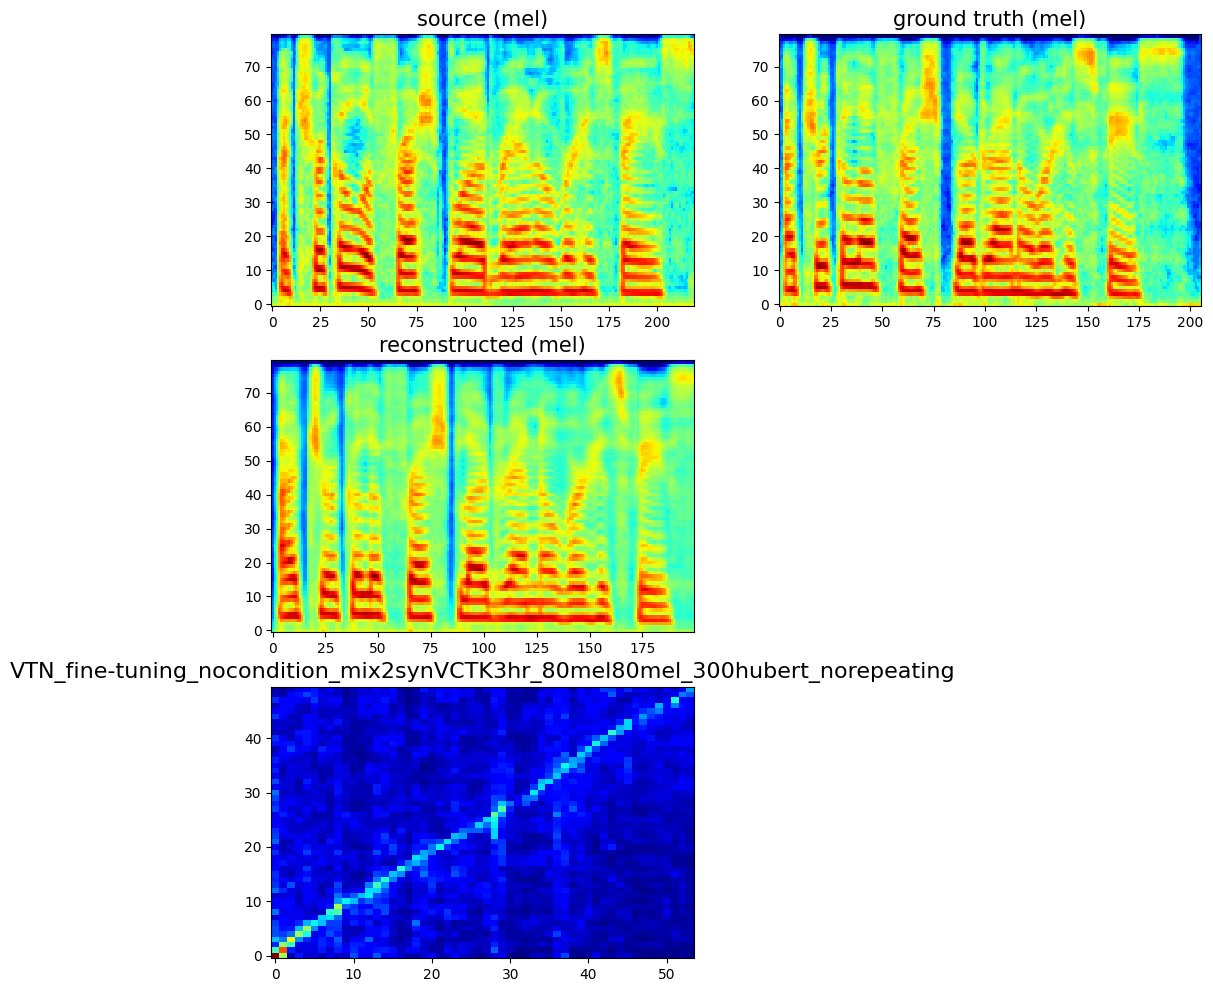

In [15]:
idx = 4
save = False
savedir = "test/vcsamples/"
if save:
    shutil.rmtree(savedir)
    os.makedirs(savedir)
with_steps = False
fs = vocoder.model.h.sampling_rate
for idx in [idx]:
# for idx in range(10):
    utt_id = dataset.files[idx]
    utt_basename = utt_id
    data = dataset[dataset.files.index(utt_id)]
    width = max(2, len(models))
    length = 3

    %matplotlib inline  
    fig = plt.figure(figsize=(6*width, 4*length))

    for m, config in enumerate(configlist):
        mn = os.path.basename(os.path.dirname(checkpoint_paths[m]))
        checkpoint = checkpoint_paths[m]
        steps = checkpoint.split("checkpoint-")[-1].split("steps")[0]
        outdir = config["outdir"] + steps + "/"
        label = labels[mn]
        if with_steps:
            label = label + "_" + steps

        if m==0:
            imelpath = os.path.join(outdir, "mel", f"input_{utt_basename}.npy")
            sourcemel = np.load(imelpath)
            sourcewav = vocoder.get(sourcemel)
            # sourcewav = sourcewav[0].numpy()

            gtmelpath = os.path.join(outdir, "mel", f"gt_{utt_basename}.npy")
            gtmel = np.load(gtmelpath)
            gtwav = vocoder.get(gtmel)
            # gtwav = gtwav[0].numpy()

            print("source")
            play_audio(sourcewav, fs)
            print("ground truth")
            play_audio(gtwav, fs)

            plot_spectrogram(sourcemel.T, fig, (length,width,1), title=f"source (mel)")
            plot_spectrogram(gtmel.T, fig, (length,width,2), title="ground truth (mel)")

            if save:
                savepath = savedir + f"{idx}_source.wav"
                write_wav(savepath, fs, sourcewav)
                savepath = savedir + f"{idx}_target.wav"
                write_wav(savepath, fs, gtwav)

        omelpath = os.path.join(outdir, "mel", f"output_{utt_basename}.npy")
        predmel = np.load(omelpath)
        # predmel = scaler["80mel"].transform(predmel)
        wavpath = os.path.join(outdir, "wav", f"{utt_basename}.wav")
        _, sr = torchaudio.load(wavpath)
        # predwav = predwav[0].numpy()
        predwav = vocoder.get(predmel)

        print(label)
        play_audio(predwav, sr)
        if save:
            savepath = savedir + f"{idx}_{label}.wav"
            sf.write(savepath, predwav, fs, "PCM_16")

        plot_spectrogram(predmel.T, fig, (length,width,width+m+1), title="reconstructed (mel)")

        probs = np.load(os.path.join(outdir, "probs", f"probs_{utt_basename}.npy"))
        attws = np.load(os.path.join(outdir, "att_ws", f"attws_{utt_basename}.npy"))
        att = np.array([attws[i][j] for i in range(attws.shape[0]) for j in range(attws.shape[1])]).mean(0)
        plot_spectrogram(att, fig, (length,width,2*width+m+1), title=label, title_font=16)
    if save:
        plt.savefig(f"{savedir}{idx}.png",  bbox_inches ="tight") 